# Prisma Diagram

Here we provide a **P**referred **R**eporting **I**tems for **S**ystematic Reviews and **M**eta-**A**nalyses (PRISMA) diagram.  PRISMA aims to improve the reporting of systematic reviews.  Full details of the PRISMA statement can be found on at [https://prisma-statement.org](https://prisma-statement.org)

The flow diagram generated visualises the manuscripts returned from multiple database searches, duplicates, titles/abstracts screened in/out; and manuscripts included excluded during full text screening.

## Overview of notebook

This notebook uses the `graphviz` library to generate a basic flow diagram.  It is separated into four sections: imports; a function to create the flow diagram; a script to populate a `dict` with the findings from our study; and the code to run function and save the image to file.  Our flow diagram illustrates results prior to forward citation chasing.

The diagram we generate here is not the same layout as specified by PRISMA 2020.  To generate a compliant diagram we format our data into a template that can be uploaded to https://estech.shinyapps.io/prisma_flowdiagram/. 

>     Haddaway, N. R., Page, M. J., Pritchard, C. C., & McGuinness, L. A. (2022). 
    PRISMA2020: An R package and Shiny app for producing PRISMA 2020-compliant 
    flow diagrams, with interactivity for optimised digital transparency 
    and Open Synthesis Campbell Systematic Reviews, 18, e1230. 
    https://doi.org/10.1002/cl2.1230

## Limitations

It was not possible to completely automate our deduplication process. This was part done using our own software (stripping whitespace and punctunctation), and part using Zotero to match probably duplicates and then manually merge. Our published dataset contains all papers we **attempted to retrieve**.  This means we can only calculate statistics the full test screening stage of our review.  

## 1. Imports

### 1.1 Graphviz imports

We have generated our PRSIMA diagram using `graphviz`

In [1]:
from graphviz import Digraph
from graphviz import Graph
import pydot

### 1.2 Standard imports

In [2]:
import pandas as pd
import numpy as np

### 1.3 Imports from preprocessing module

In [3]:
# function for loading full dataset
from preprocessing import load_clean_dataset

## 2. Constants

In [4]:
# studies pre forward search
PRE_FS = 'https://raw.githubusercontent.com/TomMonks/' \
    + 'des_sharing_lit_review/main/data/pre_forward_search/' \
    + 'before_forward_search.zip'


# all studies we included in stage 2
FILE_NAME = 'https://raw.githubusercontent.com/TomMonks/' \
    + 'des_sharing_lit_review/main/data/share_sim_data_extract.zip'

# pre-screnning file locations
POST_FIX = '../../data/pre_screening/'
POST_FIX_STAGE1 = '../../data/stage1/'
POST_FIX_FS = '../../data/forward_search/'
POST_FIX_PRE_FS = '../../data/pre_forward_search/'
SCOPUS = POST_FIX + 'Scopus_search.zip'
PUBMED = POST_FIX + 'pubmed_part.zip'
ACM = POST_FIX + '20220903_acm.zip'
WOS = POST_FIX + '20220903_wos.zip'
UNIQUE = POST_FIX_STAGE1 + 'unique_papers.zip'
FORWARD_SEARCH = POST_FIX_FS + 'forward_search_spidercite.zip'
PRE_FS = POST_FIX_PRE_FS + 'before_forward_search.zip'
FS_ASSESSED = POST_FIX_FS + 'forward_search_assessed.zip'

# for template for R shiney app to create 2020 compliant prisma diagram
TEMPLATE_FILE = 'prisma_template/PRISMA.csv'

## 3. Functions to create diagram

We provide functions to calculate basic statistics for the dataset i.e.

* number_studies_included
* studies_to_retrieve
* papers_not_retrieved
* excluded_count
* models_with_code
* A number of functions to return the number of records retrieved from the databases included in the study.

And a function to create the `graphviz` based prisma diagram.

* graph_prisma

In [5]:
def number_studies_included(df):
    '''
    Return the number of studies included after screening.
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[df['study_included'] == 1])

In [6]:
def studies_to_retrieve(df):
    '''
    Return the number of studies to retrieve after screening
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df)

In [7]:
def papers_not_retrieved(df):
    '''
    Return the number of studies not retrieved.
    These are labelled as 'Full Text Not Availabe'
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[df['excluded_reason'] == 'Full Text Not Available'])

In [8]:
def excluded_count(df, reason):
    '''
    Return the number of studies excluded with a specific reason.
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[df['excluded_reason'] == reason])

In [9]:
def models_with_code(df):
    '''
    Return the number of included studies that shared DES models.
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[(df['study_included'] == 1) & 
                   (df['model_code_available'] == 1)])

In [10]:
def returned_from_scopus_after_dedup():
    '''
    Returns the number from scopus after deduplication.
    '''
    total = 0
    for yr in range(2019, 2023):
        total += len(pd.read_csv(SCOPUS[str(yr)]))
    return total

In [11]:
def returned_from_scopus_before_dedup():
    '''
    Returns the number from PubMed BEFORE deduplication.
    '''
    return len(pd.read_csv(SCOPUS))

In [12]:
def returned_from_pubmed_before_dedup():
    '''
    Returns the number from PubMed BEFORE deduplication.
    '''
    return len(pd.read_csv(PUBMED))

In [13]:
def returned_from_acm_before_dedup():
    '''
    Returns the number from ACM Digital Library BEFORE deduplication.
    '''
    return len(pd.read_csv(ACM))

In [14]:
def returned_from_wos_before_dedup():
    '''
    Returns the number from Web of Science BEFORE deduplication.
    '''
    return len(pd.read_csv(WOS))

In [15]:
def returned_unique_papers():
    '''
    Returns the number from unique papers after dedup
    '''
    return len(pd.read_csv(UNIQUE))

In [16]:
def graph_prisma(data, filename='prisma.dot', show_subgraph=True):
    '''
    Create PRISMA flow diagram for literature review

    The output is saved in a dot format file.

    Params:
    -------
    data: dict
      Dictionary of data items
      
    Returns:
    --------
    Diagraph

    '''
    g = Digraph('PRISMA', filename=filename)

    #g.attr(label=r"\n\nPrisma Flow Diagram")
    # need to use layout='neato' to control exact position /
    g.attr(fontsize='14')
    
    common_attributes = {'width':'2cm', 'height':'1cm'}

    node1_txt = f"Records identified from: \nScopus " \
        + f"(n = {str(data['scopus_n'])}) \nPubMed " \
        + f"(n = {str(data['pubmed_n'])}) \nACM " \
        + f"(n = {str(data['acm_n'])}) \nWoS " \
        + f"(n = {str(data['wos_n'])})"
    # if using neato could try pos argument e.g. pos='1,2'
    node1 = g.node('A', node1_txt, shape='rectangle', **common_attributes)

    node2_txt = f"Records removed:\n" \
        + f"duplicates (n = {str(data['n_duplicates'])})"
    node2 = g.node('B', node2_txt, shape='rectangle', **common_attributes)

    node3_txt = f"Records screened\n (n = {str(data['n_title_abstract'])})"
    node3 = g.node('C', node3_txt, shape='rectangle', **common_attributes)

    node4_txt = f"Records excluded\n " \
        + f"(n = {str(data['n_abstracts_excluded'])})"
    node4 = g.node('D', node4_txt, shape='rectangle', **common_attributes)

    node5_txt = f"Papers sought for retrieval\n " \
        + f"(n = {str(data['n_to_retrieve'])})"
    node5 = g.node('E', node5_txt, shape='rectangle', **common_attributes)

    node6_txt = f"Papers not retrieved\n (n = {str(data['n_not_retrieved'])})"
    node6 = g.node('F', node6_txt, shape='rectangle', **common_attributes)

    node6_txt = f"Papers assessed for eligibility\n" \
        + f"(n = {str(data['n_assessed'])})"
    node6 = g.node('G', node6_txt, shape='rectangle', **common_attributes)


    # excluded reasons
    node8_txt = f"Excluded at full text:\n" \
        + f"{data['exclude_reason1']} (n = {str(data['n_exclude_reason1'])})\n"\
        + f"{data['exclude_reason2']} (n = {str(data['n_exclude_reason2'])})\n"\
        + f"{data['exclude_reason3']} (n = {str(data['n_exclude_reason3'])})\n"\
        + f"{data['exclude_reason4']} (n = {str(data['n_exclude_reason4'])})"
    node8 = g.node('I', node8_txt, shape='rectangle')
    
    node7_txt = f"Studies included in review\n(n = {str(data['n_included'])})"
    node7 = g.node('H', node7_txt, shape='rectangle', **common_attributes)

    g.edges(['AB', 'AC', 'CD', 'CE', 'EF', 'EG', 'GI', 'GH'])


    if show_subgraph:
        # subnodes for best practice audit
        snode1_txt = f"Available models\n n = {str(data['available_models_n'])}" 
        snode1 = g.node('H0', snode1_txt)

        snode2_txt = f"Included studies \n n = {str(data['n_included'])}"
        snode2 = g.node('H1', snode2_txt)

        snode3_txt = f"Percentage of models shared \n {str(data['percent'])}"
        snode3 = g.node('H2', snode3_txt)

        with g.subgraph(name='cluster_1') as c:
            c.attr(color='blue')
            c.node_attr['style'] = 'filled'
            c.edges([('H0', 'H2'), ('H1', 'H2')])
            c.attr(label="Available DES models")

    g.save(filename)
    return g

In [17]:
def results_in_r_shiney_format(file_name):
    '''
    Format results so they can be uploaded to R Shiney app that creates
    a 2020 compliant PRISMA diagram.
    
    Params:
    ------
    file_name: str
        File path for prisma template compatible with app.
    
    Returns:
    --------
    pd.DataFrame
    
    References:
    ------
    Haddaway, N. R., Page, M. J., Pritchard, C. C., & McGuinness, L. A. (2022). 
    PRISMA2020: An R package and Shiny app for producing PRISMA 2020-compliant 
    flow diagrams, with interactivity for optimised digital transparency 
    and Open Synthesis Campbell Systematic Reviews, 18, e1230. 
    https://doi.org/10.1002/cl2.1230
    
    https://estech.shinyapps.io/prisma_flowdiagram/
    '''
    
    # load template
    shiney_template = pd.read_csv(TEMPLATE_FILE, index_col='data')
    
    database_specific_results = f"Scopus, {data['scopus_n']}; " \
    + f"PubMed, {data['pubmed_n']};  " \
    + f"ACM, {data['acm_n']}; WoS, {data['wos_n']}"

    dbr_excluded = f"{EXCLUDED_REASON_1}, " \
        + f"{excluded_count(clean_pre_fs, EXCLUDED_REASON_1)}; " \
        + f"{EXCLUDED_REASON_2}, " \
        + f"{excluded_count(clean_pre_fs, EXCLUDED_REASON_2)}; " \
        + f"{EXCLUDED_REASON_3}, " \
        + f"{excluded_count(clean_pre_fs, EXCLUDED_REASON_3)}; "

    other_excluded = f"{EXCLUDED_REASON_2}, " \
        + f"{excluded_count(clean_fs_assessed, EXCLUDED_REASON_2)}; " \
        + f"Preprint, " \
        + f"{excluded_count(clean_fs_assessed, EXCLUDED_REASON_4)};"
    
    # database search results
    shiney_template.loc['database_specific_results', 'n'] = \
        database_specific_results

    shiney_template.loc['database_specific_results', 'node'] = 'node7'

    shiney_template.loc['database_results', 'n'] = 'NaN'
    shiney_template.loc['register_results', 'n'] = 'NaN'

    # duplicates
    shiney_template.loc['duplicates', 'n'] = data['n_duplicates']
    shiney_template.loc['excluded_automatic', 'n'] = 'NaN'
    shiney_template.loc['excluded_other', 'n'] = 'NaN'

    # records screened (no. titles and abstracts) and excluded at stage 1
    shiney_template.loc['records_screened', 'n'] = data['n_title_abstract']
    # excluded at stage 1
    shiney_template.loc['records_excluded', 'n'] = data['n_abstracts_excluded']

    # papers sort for retrieval and not retrieved at stage 2 (full text)
    shiney_template.loc['dbr_sought_reports', 'n'] = data['n_to_retrieve']
    shiney_template.loc['dbr_notretrieved_reports', 'n'] = \
        data['n_not_retrieved']

    # papers assessed and excluded + reasons
    shiney_template.loc['dbr_assessed', 'n'] = data['n_assessed']
    shiney_template.loc['dbr_excluded', 'n'] = dbr_excluded

    # studies included in review
    shiney_template.loc['new_studies', 'n'] = data['n_included_after_fs']
    shiney_template.loc['new_reports', 'n'] = 'NaN'

    # forward search via spidercite
    shiney_template.loc['citations_results', 'n'] = data['n_forward_search']
    shiney_template.loc['citations_results', 'boxtext'] = 'Spidercite'
    shiney_template.loc['organisation_results', 'n'] = 'NaN'
    shiney_template.loc['website_results', 'n'] = 'NaN'

    shiney_template.loc['other_sought_reports', 'n'] = \
        data['n_forward_included']
    shiney_template.loc['other_notretrieved_reports', 'n'] = 0

    # included excluded
    shiney_template.loc['other_assessed', 'n'] =  data['n_forward_included']
    shiney_template.loc['other_excluded', 'n'] =  other_excluded
    
    return shiney_template

## 4. Read in data

In [18]:
# studies from main databases search
clean_pre_fs = load_clean_dataset(PRE_FS)

# studies found using forward search via spidercite
df_fs = pd.read_csv(FORWARD_SEARCH)

# studies assessed after forward search screening
clean_fs_assessed = load_clean_dataset(FS_ASSESSED)

# all students including those from forward search
clean = load_clean_dataset(FILE_NAME)


## 3. Diagram Data Input
The constant below represent values obtained from searching Scopus and Pubmed and cannot be generated from our dataset.

In [19]:
# totals by database
N_SCOPUS = returned_from_scopus_before_dedup()
N_PUBMED = returned_from_pubmed_before_dedup()
N_ACM = returned_from_acm_before_dedup()
N_WOS = returned_from_wos_before_dedup()
N_TOTAL = N_SCOPUS + N_PUBMED + N_ACM + N_WOS 

# no. unique papers after semi-automated dedup
N_UNIQUE = returned_unique_papers()

# no. duplicates removed.
DUPLICATES_REMOVED = N_TOTAL - N_UNIQUE

# total abstracts/titles to sceen in stage 1
N_TITLE_ABSTRACTS = N_UNIQUE

# number excluded by stage 1 screening process
N_ABSTRACTS_EXCLUDED = N_UNIQUE - studies_to_retrieve(clean_pre_fs) 

# reasons for exclusion in stage 2 (excluding not able to retrieve)
EXCLUDED_REASON_1 = "Not English"
EXCLUDED_REASON_2 = "Not DES"
EXCLUDED_REASON_3 = "Not Health"
EXCLUDED_REASON_4 = "PRE PRINT"

In [20]:
#  script for prisma
data = {}
data['scopus_n'] = N_SCOPUS
data['pubmed_n'] = N_PUBMED
data['acm_n'] = N_ACM
data['wos_n'] = N_WOS
data['unique_n'] = N_UNIQUE
data['n_duplicates'] = DUPLICATES_REMOVED
data['n_title_abstract'] = N_TITLE_ABSTRACTS
data['n_abstracts_excluded'] = N_ABSTRACTS_EXCLUDED
data['n_to_retrieve'] = studies_to_retrieve(clean_pre_fs)
data['n_not_retrieved'] = papers_not_retrieved(clean_pre_fs)
data['n_assessed'] = studies_to_retrieve(clean_pre_fs) \
    - papers_not_retrieved(clean_pre_fs)
data['n_included'] = number_studies_included(clean_pre_fs)
data['exclude_reason1'] = EXCLUDED_REASON_1
data['exclude_reason2'] = EXCLUDED_REASON_2
data['exclude_reason3'] = EXCLUDED_REASON_3
data['exclude_reason4'] = EXCLUDED_REASON_4
data['n_exclude_reason1'] = excluded_count(clean_pre_fs, EXCLUDED_REASON_1)
data['n_exclude_reason2'] = excluded_count(clean_pre_fs, EXCLUDED_REASON_2)
data['n_exclude_reason3'] = excluded_count(clean_pre_fs, EXCLUDED_REASON_3)
data['n_exclude_reason4'] = excluded_count(clean_pre_fs, EXCLUDED_REASON_4)
data['available_models_n'] = models_with_code(clean_pre_fs)
data['percent'] = round((models_with_code(clean_pre_fs) / \
                         number_studies_included(clean_pre_fs)) \
                        * 100, 1)

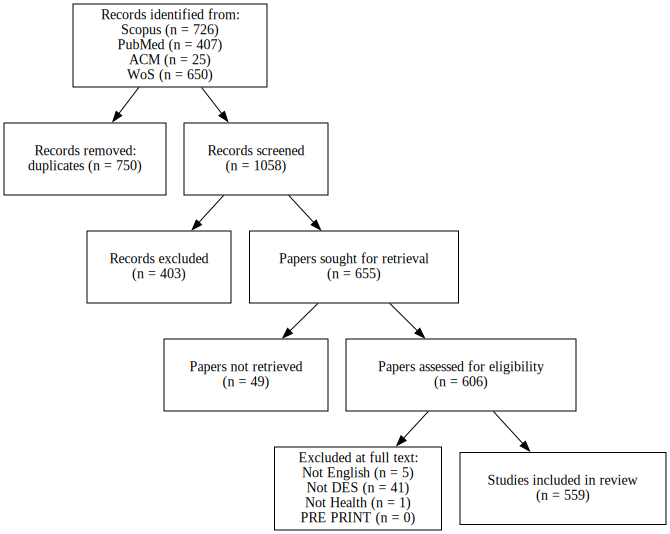

In [21]:
 # Pre - forward search
g = graph_prisma(data, show_subgraph=False)
g

In [22]:
# save to file
(graph,) = pydot.graph_from_dot_file('prisma.dot')
graph.set_dpi(400)
graph.write_png('prisma.png')

## Forward Search

The forward search was conducted using spidercite.  We uploaded the papers that contained code only. 

In [23]:
data['n_forward_search'] = len(df_fs)
data['n_forward_included'] = len(clean) - len(clean_pre_fs)

In [24]:
data['n_forward_search']

430

In [25]:
data['n_forward_included']

10

In [26]:
data['n_included_after_fs'] = number_studies_included(clean)

In [27]:
data['n_included_after_fs']

564

## Add results to PRISMA template via R Shiney App

In [28]:
shiney_template = results_in_r_shiney_format(TEMPLATE_FILE)

In [29]:
shiney_template.head(2)

,node,box,description,boxtext,tooltips,url,n,Unnamed: 8,Unnamed: 9
data,,,,,,,,,
NaN,node4,prevstud,Grey title box,Previous studies,Previous studies,Grey title box,Previous studies,prevstud.html,0.0
previous_studies,node5,box1,Studies included in previous version of review,Studies included in previous version of review,Studies included in previous version of review,previous_studies.html,0,NaN,NaN


In [30]:
# save to file so can be uploaded.
shiney_template.to_csv('completed_prisma.csv')

## Output from PRISMA diagram app.

In [40]:
from IPython.display import IFrame

IFrame(src='./prisma.html', width=1050, height=600)